In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("creditcard.csv")

In [45]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']

In [12]:
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)

# Picking the indices of the normal classes
normal_indices = data[data.Class == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = data.iloc[under_sample_indices,:]

X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'Class']

# Showing ratio
print("Number of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0]))
print("Number of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1]))
print("Total number of transactions in resampled data: ", len(under_sample_data))

('Number of normal transactions: ', 492)
('Number of fraud transactions: ', 492)
('Total number of transactions in resampled data: ', 984)


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Number transactions train dataset: ", len(X_train_undersample))
print("Number transactions test dataset: ", len(X_test_undersample))
print("Total number of transactions: ", len(X_train_undersample)+len(X_test_undersample))

('Number transactions train dataset: ', 199364)
('Number transactions test dataset: ', 85443)
('Total number of transactions: ', 284807)

('Number transactions train dataset: ', 688)
('Number transactions test dataset: ', 296)
('Total number of transactions: ', 984)


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

C:\Users\Pankaj Sharma\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [16]:

fold = KFold(len(y_train_undersample),5,shuffle=False) 

# Different C parameters
c_param_range = [0.01,0.1,1,10,100]
results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','Mean recall score'])
results_table['C_parameter'] = c_param_range

# the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
j = 0
for c_param in c_param_range:
    print('-------------------------------------------')
    print('C parameter: ', c_param)
    print('-------------------------------------------')
    print('')

    recall_accs = []
    for iteration, indices in enumerate(fold,start=1):
    
        # Call the logistic regression model with a certain C parameter
        lr = LogisticRegression(C = c_param, penalty = 'l1')
        # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
        # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
        lr.fit(X_train_undersample.iloc[indices[0],:],y_train_undersample.iloc[indices[0],:].values.ravel())

        # Predict values using the test indices in the training data
        y_pred_undersample = lr.predict(X_train_undersample.iloc[indices[1],:].values)

        # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
        recall_acc = recall_score(y_train_undersample.iloc[indices[1],:].values,y_pred_undersample)
        recall_accs.append(recall_acc)
        print('Iteration ', iteration,': recall score = ', recall_acc)
    # The mean value of those recall scores is the metric we want to save and get hold of.
    results_table.loc[j,'Mean recall score'] = np.mean(recall_accs)
    j += 1
    print('')
    print('Mean recall score ', np.mean(recall_accs))
    print('')


-------------------------------------------
('C parameter: ', 0.01)
-------------------------------------------

('Iteration ', 1, ': recall score = ', 0.7945205479452054)
('Iteration ', 2, ': recall score = ', 0.8356164383561644)
('Iteration ', 3, ': recall score = ', 0.864406779661017)
('Iteration ', 4, ': recall score = ', 0.8918918918918919)
('Iteration ', 5, ': recall score = ', 0.8939393939393939)

('Mean recall score ', 0.8560750103587343)

-------------------------------------------
('C parameter: ', 0.1)
-------------------------------------------

('Iteration ', 1, ': recall score = ', 0.863013698630137)
('Iteration ', 2, ': recall score = ', 0.8767123287671232)
('Iteration ', 3, ': recall score = ', 0.9661016949152542)
('Iteration ', 4, ': recall score = ', 0.9459459459459459)
('Iteration ', 5, ': recall score = ', 0.8939393939393939)

('Mean recall score ', 0.9091426124395708)

-------------------------------------------
('C parameter: ', 1)
--------------------------------

In [19]:
best_c=100

In [60]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

('Recall metric in the testing dataset: ', 0.9319727891156463)


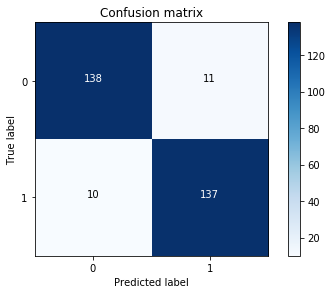

In [61]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", float(cnf_matrix[1,1])/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

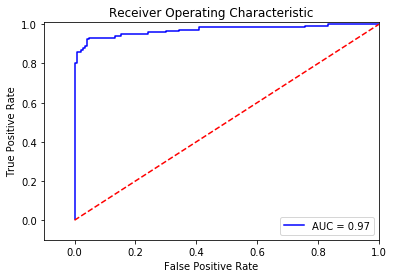

In [62]:
# ROC CURVE(Receiver Operating Characteristic)
lr = LogisticRegression(C = best_c, penalty = 'l1')
y_pred_undersample_score = lr.fit(X_train_undersample,y_train_undersample.values.ravel()).decision_function(X_test_undersample.values)

fpr, tpr, thresholds = roc_curve(y_test_undersample.values.ravel(),y_pred_undersample_score)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [63]:
fold = KFold(len(y_train),5,shuffle=False) 

# Different C parameters
c_param_range = [0.01,0.1,1,10,100]
results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','Mean recall score'])
results_table['C_parameter'] = c_param_range

# the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
j = 0
for c_param in c_param_range:
    print('-------------------------------------------')
    print('C parameter: ', c_param)
    print('-------------------------------------------')
    print('')

    recall_accs = []
    for iteration, indices in enumerate(fold,start=1):
    
        # Call the logistic regression model with a certain C parameter
        lr = LogisticRegression(C = c_param, penalty = 'l1')
        # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
        # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
        lr.fit(X_train.iloc[indices[0],:],y_train.iloc[indices[0],:].values.ravel())

        # Predict values using the test indices in the training data
        y_pred= lr.predict(X_train.iloc[indices[1],:].values)

        # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
        recall_acc = recall_score(y_train.iloc[indices[1],:].values,y_pred)
        recall_accs.append(recall_acc)
        print('Iteration ', iteration,': recall score = ', recall_acc)
    # The mean value of those recall scores is the metric we want to save and get hold of.
    results_table.loc[j,'Mean recall score'] = np.mean(recall_accs)
    j += 1
    print('')
    print('Mean recall score ', np.mean(recall_accs))
    print('')


-------------------------------------------
('C parameter: ', 0.01)
-------------------------------------------

('Iteration ', 1, ': recall score = ', 0.47761194029850745)
('Iteration ', 2, ': recall score = ', 0.5616438356164384)
('Iteration ', 3, ': recall score = ', 0.6333333333333333)
('Iteration ', 4, ': recall score = ', 0.5692307692307692)
('Iteration ', 5, ': recall score = ', 0.425)

('Mean recall score ', 0.5333639756958096)

-------------------------------------------
('C parameter: ', 0.1)
-------------------------------------------

('Iteration ', 1, ': recall score = ', 0.582089552238806)
('Iteration ', 2, ': recall score = ', 0.6438356164383562)
('Iteration ', 3, ': recall score = ', 0.6833333333333333)
('Iteration ', 4, ': recall score = ', 0.5846153846153846)
('Iteration ', 5, ': recall score = ', 0.5125)

('Mean recall score ', 0.6012747773251761)

-------------------------------------------
('C parameter: ', 1)
-------------------------------------------

('Iteratio

('Recall metric in the testing dataset: ', 0.6190476190476191)


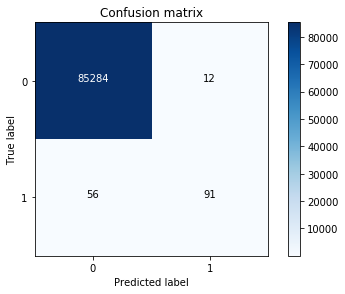

In [64]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train,y_train.values.ravel())
y_pred = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", float(cnf_matrix[1,1])/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()


('Recall metric in the testing dataset: ', 0.9591836734693877)
('Recall metric in the testing dataset: ', 0.9523809523809523)
('Recall metric in the testing dataset: ', 0.9319727891156463)
('Recall metric in the testing dataset: ', 0.9319727891156463)
('Recall metric in the testing dataset: ', 0.9319727891156463)
('Recall metric in the testing dataset: ', 0.9319727891156463)
('Recall metric in the testing dataset: ', 0.9251700680272109)
('Recall metric in the testing dataset: ', 0.891156462585034)
('Recall metric in the testing dataset: ', 0.8707482993197279)


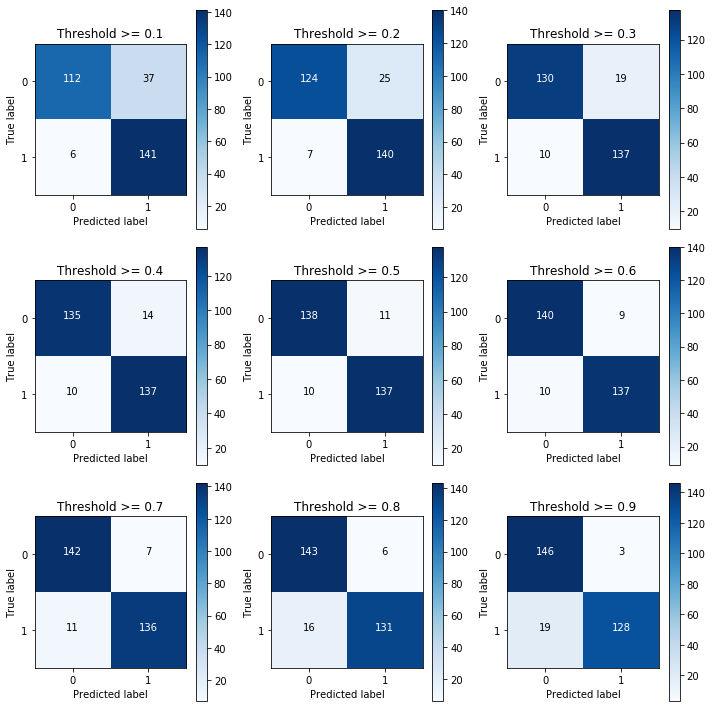

In [68]:
lr = LogisticRegression(C = 100, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(10,10))

j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_undersample_proba[:,1] > i
    
    plt.subplot(3,3,j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test_undersample,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    print("Recall metric in the testing dataset: ", float(cnf_matrix[1,1])/(cnf_matrix[1,0]+cnf_matrix[1,1]))

    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Threshold >= %s'%i) 

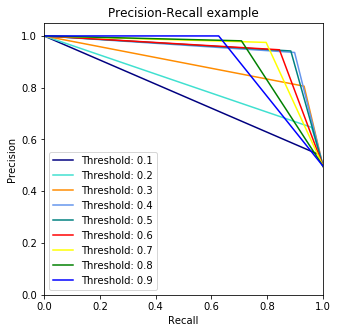

In [66]:
from itertools import cycle

lr = LogisticRegression(C = 0.01, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(5,5))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = y_pred_undersample_proba[:,1] > i
    
    precision, recall, thresholds = precision_recall_curve(y_test_undersample,y_test_predictions_prob)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example')
    plt.legend(loc="lower left")